In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
from itertools import permutations
from itertools import combinations
from pyEDM import *
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
import time
import os
import math
import random
from scipy.stats import ttest_ind

from IPython.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))

import warnings
warnings.filterwarnings("ignore", 
    message="A worker stopped while some jobs were given to the executor.",
    module="joblib.externals.loky.process_executor")

In [2]:
def get_block(data, num_lags=1, tau=1):
    ''' Get a dataframe with all the possible valid lags of the variables. '''
    
    backward_lags = pd.concat([data[var].shift(lag*tau).rename(f'{var}(t-{lag*tau})') for lag in range(num_lags+1) for var in data.columns], axis=1)
    forward_lags  = pd.concat([data[var].shift(-1*lag*tau).rename(f'{var}(t+{lag*tau})') for lag in range(1,num_lags+1) for var in data.columns], axis=1)
    block = pd.concat([backward_lags, forward_lags], axis=1)

    return block

In [3]:
def get_xmap_results_smap(block, target, embeddings, Tp, theta, lib, pred):
    '''Function to do exhaustive search of embeddings.'''
    
    def compute_rho(block, target, embedding, Tp, theta, lib, pred):
        xmap = SMap(dataFrame=block, target=target, columns=embedding, Tp=Tp, theta=theta, embedded=True, lib=lib, pred=pred, noTime=True)
        rho = xmap['predictions'][['Observations', 'Predictions']].corr().iloc[0,1]
        return embedding, xmap['predictions'], rho

    xmap_results = pd.DataFrame(columns=['embedding', 'rho'])
    xmap_results = Parallel(n_jobs=-1)(delayed(compute_rho)(block, target, embedding, Tp, theta, lib, pred) for embedding in embeddings)
    xmap_results = pd.DataFrame(xmap_results, columns=['embedding', 'result', 'rho'])
    xmap_results = xmap_results.sort_values(by='rho', ascending=False).reset_index(drop=True)
    
    return xmap_results

In [4]:
# Multiview Cross-Mapping Function

def MVCM(block, target, xmap_results, Tp, gap_radius, theta, lib, pred, E, k, self_weight):
    
    # Get lib and pred indices, adjusted to match pyEDM
    lib_start, lib_end = map(int, lib.split())
    pred_start, pred_end = map(int, pred.split())
    lib_start -= 1; lib_end -= 1
    pred_start -= 1; pred_end -= 1
    
    if Tp > 0:
        pred_end += Tp
    elif Tp < 0:
        pred_start -= -1 * Tp
    
    # If k > number of system views, return NaNs as the filtered timeseries
    if k > len(xmap_results):
        filtered_timeseries = pd.DataFrame([np.nan] * len(xmap_results.loc[0,'result']['Predictions']))
        print(f'K={k} is bigger than number of system views')
        return filtered_timeseries
    
    filter_input = pd.DataFrame()
    filter_input = pd.concat([xmap_results.loc[i,'result']['Predictions'] for i in range(0,k)], axis=1)
    filter_input.index = block.loc[pred_start:pred_end,:].index
    
    self = block.loc[pred_start:pred_end,f'{target}(t-0)']
    self.index = range(pred_start,pred_end+1)
    filter_input['self'] = self
    filter_input['vals_to_avg'] = filter_input.apply(lambda row: row.tolist(), axis=1)
    
    # Get weights based on cross-map skill of embeddings
    weights = xmap_results.loc[:k-1,'rho'].tolist()
    weights = [x if x >= 0 else 0 for x in weights]                  # Make negative weights 0
    
    if np.sum(weights) > 0:
        weights = [(1 - self_weight/100)*(weight/np.sum(weights)) for weight in weights]
    else:
        weights = [(1 - self_weight/100)*(1/len(weights)) for weight in weights]
    
    weights = weights + [self_weight/100]
    filter_input['weights'] = [weights] * len(filter_input)
    
    # Get filtered values
    vals_to_avg = np.array(filter_input['vals_to_avg'].tolist())
    weights = np.array(filter_input['weights'].tolist())

    filter_input['filtered_points'] = np.nansum(vals_to_avg * weights, axis=1)
    
    filtered_timeseries = filter_input[['filtered_points']].copy()
    
    # Make sure filtered values are positive
    filtered_timeseries[filtered_timeseries<0] = 0
    
    return filtered_timeseries

In [5]:
def optimize_parameters_MVCM(block, target, all_xmap_results, Tp, gap_radius, lib, pred, E_list, k_list, theta_list):
    
    # Get lib and pred indices, adjusted to match pyEDM
    lib_start, lib_end = map(int, lib.split())
    pred_start, pred_end = map(int, pred.split())
    lib_start -= 1; lib_end -= 1
    pred_start -= 1; pred_end -= 1
    
    # Optimize parameters using a self_weight of 0 until a self_weight is chosen at the end
    self_weight = 0
    
    # Choose the E, k, and theta that give the best multiview cross-map prediction of the observed data with a self_weight of 0

    xmap_results_dict = {}
    
    # Get multiview cross-map predictions for E, k, and theta combinations
    mvcm_results = pd.DataFrame(columns=['E', 'k', 'theta', 'rho', 'xmap_results', 'noisy_and_filtered'])
    
    total_iterations = len(list(product(E_list, theta_list, k_list)))
    #with tqdm(total=total_iterations) as pbar:
    for E, theta in product(E_list, theta_list):

        # Get random embeddings and their cross-map skill
        xmap_results = {k: v for k, v in all_xmap_results.items() if (k.split('_')[0] == target) & 
                                                            (k.split('_')[1] == lib) &
                                                            (k.split('_')[2] == str(E)) &
                                                            (k.split('_')[3] == str(theta))}
        key = list(xmap_results.keys())[0]
        xmap_results = xmap_results[key]
        xmap_results_dict['{0}_{1}'.format(E, theta)] = xmap_results

        # Get multiview cross-map predictions for ks in k_list 
        for k in k_list:

            filtered = MVCM(block, target, xmap_results_dict[f'{str(E)}_{str(theta)}'], Tp, gap_radius, theta, lib, pred, E, k, self_weight)

            # Align indices of noisy target with indices of filtered_timeseries
            noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']
            noisy_and_filtered = pd.concat([noisy_target, filtered], axis=1)
            noisy_and_filtered.columns = [f'noisy_{target}', f'filtered_{target}']
            rho = noisy_and_filtered.corr().iloc[0,1]
            mvcm_results.loc[len(mvcm_results)] = [E, k, theta, rho, xmap_results, noisy_and_filtered]
                #pbar.update(1)

    mvcm_results = mvcm_results.sort_values(by='rho', ascending=False).reset_index(drop=True)
    
    E = int(mvcm_results.loc[0,'E'])
    k = int(mvcm_results.loc[0,'k'])
    theta = int(mvcm_results.loc[0,'theta'])
    
    return E, k, theta, mvcm_results

In [6]:
HAB_data = pd.read_csv('Data/data_w_gaps_and_wind.csv', index_col=0).iloc[:800] 
HAB_data = HAB_data.reset_index()
HAB_data.columns = HAB_data.columns.str.replace(' ', '_')

# Put columns in alphabetical order
sorted_columns = sorted(HAB_data.columns)
HAB_data = HAB_data[sorted_columns]
HAB_data = HAB_data.set_index('time')
target = 'Avg_Chloro'

# Make indices integers and save mapping to dates
#date_to_int_map = {i: date for i, date in enumerate(HAB_data.index)}
#HAB_data.index = range(len(HAB_data))

HAB_data
block = get_block(HAB_data, num_lags=50, tau=1)
block

,AVG_DENS_kgm3(t-0),AVG_SAL_PSU(t-0),AVG_TEMP_C(t-0),Avg_Chloro(t-0),BOT_DENS_kgm3(t-0),BOT_SAL_PSU(t-0),BOT_TEMP_C(t-0),Nitrate(t-0),Nitrite(t-0),Phosphate(t-0),...,BOT_SAL_PSU(t+50),BOT_TEMP_C(t+50),Nitrate(t+50),Nitrite(t+50),Phosphate(t+50),SURF_DENS_kgm3(t+50),SURF_SAL_PSU(t+50),SURF_TEMP_C(t+50),Silicate(t+50),WSPD(t+50)
time,,,,,,,,,,,,,,,,,,,,,
0,1024.129374,33.695,18.10,1.82,1024.620655,33.62,15.9,0.43,0.03,0.24,...,33.66,19.3,0.37,0.0,0.28,1023.818956,33.70,19.4,6.3,4.591667
7,1024.289049,33.640,17.35,2.71,1024.391719,33.62,16.9,0.83,0.04,0.37,...,33.67,20.0,0.34,0.0,0.24,1023.686670,33.73,20.0,5.4,3.308333
13,1023.563298,33.660,20.25,0.99,1024.026040,33.58,18.3,0.45,0.00,0.24,...,33.66,20.6,0.32,0.0,0.28,1023.525345,33.69,20.5,4.2,3.883333
20,1023.740812,33.650,9.90,1.23,1023.780535,33.62,19.4,0.34,0.00,0.17,...,33.52,13.6,0.71,0.0,0.32,1023.998606,33.54,18.2,4.7,2.491667
28,1023.004896,33.710,11.25,2.41,1023.000725,33.69,22.5,0.29,0.00,0.12,...,33.48,17.2,0.17,0.0,0.26,1023.662548,33.56,19.6,0.0,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,1024.078066,33.185,16.75,1.52,1024.389556,33.17,15.4,0.44,0.00,0.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5572,1023.529663,33.320,19.45,2.67,1023.676262,33.28,18.8,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5579,1023.657238,33.255,18.70,1.60,1024.073813,33.20,16.9,0.25,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print(HAB_data.isna().sum())

AVG_DENS_kgm3     94
AVG_SAL_PSU       91
AVG_TEMP_C        92
Avg_Chloro        10
BOT_DENS_kgm3     91
BOT_SAL_PSU       88
BOT_TEMP_C        91
Nitrate            0
Nitrite            0
Phosphate          0
SURF_DENS_kgm3    52
SURF_SAL_PSU      50
SURF_TEMP_C       50
Silicate           0
WSPD              32
dtype: int64


In [8]:
def get_block(data, num_lags=1, tau=1):
    ''' Get a dataframe with all the possible valid lags of the variables. '''
    
    backward_lags = pd.concat([data[var].shift(lag*tau).rename(f'{var}(t-{lag*tau})') for lag in range(num_lags+1) for var in data.columns], axis=1)
    forward_lags  = pd.concat([data[var].shift(-1*lag*tau).rename(f'{var}(t+{lag*tau})') for lag in range(1,num_lags+1) for var in data.columns], axis=1)
    block = pd.concat([backward_lags, forward_lags], axis=1)
    
    return block

In [9]:
def ccm(interaction, block, E_list, tau_list, theta_list, Tp, sample=50, sig=0.05):
    #solver = HistGradientBoostingRegressor() #TRYING DIFFERNT SOLVER TO ENSURE CONVERGENCE



    print(interaction)
    lib = f'1 {len(block)}'
    
    # Get dataframe with two species of interest
    A = interaction[0]; B = interaction[1]
    df = block[[f'{A}(t-0)', f'{B}(t-0)']]
    
    driver = f'{A}(t-0)'    
    default_output = {
        'target (driver)': A,
        'lib (driven)': B,
        'E': None,
        'tau': None,
        'theta': None,
        'E_tau_theta_results': None,
        'ccm_value': None,
        'convergence_p_value': None,
        'correlation': None
    }
    
    E_tau_theta_results = pd.DataFrame(columns = ['E', 'tau', 'theta', 'rho'])
    for E, tau, theta in list(product(E_list, tau_list, theta_list)):
        driven_embedded = [f'{B}(t{i})' if i < 0 else f'{B}(t-{i})' for i in range(E * tau, 1)]
        driven_embedded = driven_embedded[::tau][:E]
        try:
            c = SMap(dataFrame=block, target=driver, columns=driven_embedded, embedded=True, Tp=Tp, theta=theta, lib=lib, pred=lib, noTime=True)
        except:
            print(f"{interaction} did not converge")
            return default_output
        c = c['predictions'][['Observations', 'Predictions']]
        rho = c.corr().iloc[0,1]
        E_tau_theta_results.loc[len(E_tau_theta_results)] = [E, tau, theta, rho]
    E_tau_theta_results = E_tau_theta_results.apply(pd.to_numeric, errors='coerce')

    # Assign E, tau, and theta to be the optimal E, tau, and theta
    ccm_value = E_tau_theta_results['rho'].max()
    E = int(E_tau_theta_results.loc[np.where(E_tau_theta_results.rho==ccm_value),'E'].item())
    tau = int(E_tau_theta_results.loc[np.where(E_tau_theta_results.rho==ccm_value),'tau'].item())
    theta = int(E_tau_theta_results.loc[np.where(E_tau_theta_results.rho==ccm_value),'theta'].item())
        
    # Get convergence p-value
    try:
        convergence_p_value = get_convergence_p_value(block, sample, A, B, E, Tp, tau, theta)
    except:
        print(f"{interaction} did not converge")
        return default_output

    # Preparing Output
    output = {
        'target (driver)': A,
        'lib (driven)': B,
        'E': E,
        'tau': tau,
        'theta': theta,
        'E_tau_theta_results': E_tau_theta_results,
        'ccm_value': ccm_value,
        'convergence_p_value': convergence_p_value,
        'correlation': df.corr().iloc[0,1]
    }

    return output

def get_convergence_p_value(df, sample, A, B, E, Tp, tau, theta):
    # Get convergence p-value for CCM (one-tailed t-test on cross-map values using 20% and 50% library sizes)
    # H0: μ_20% ≥ μ_50%
    # HA: μ_20% < μ_50%
    # If p < 0.05, the 20% library size trials have a rho that is significantly smaller than the 50% library trials  
    
    libsize1 = int(np.ceil(df.shape[0]/5))   # 20% of the full library size
    libsize2 = int(np.ceil(df.shape[0]/2))   # 50% of the full library size
    
    max_iterations = 10 * sample
    
    # Get list of rhos for libsize1
    rhos1 = []; iteration_count = 0
    while len(rhos1) < sample and iteration_count < max_iterations:
        start = np.random.randint(libsize1, len(df))
        library = [start - libsize1, start]
        data_subset = df.iloc[library[0]:library[1]]
        lib = f'{library[0]+1} {library[1]+1}'
        driver = f'{A}(t-0)'
        driven_embedded = [f'{B}(t{i})' if i < 0 else f'{B}(t-{i})' for i in range(E * tau, 1)]
        driven_embedded = driven_embedded[::tau][:E]
        c = SMap(dataFrame=block, target=driver, columns=driven_embedded, embedded=True, Tp=Tp, theta=theta, lib=lib, pred=lib, noTime=True)
        c = c['predictions'][['Observations', 'Predictions']]
        rho1 = c.corr().iloc[0,1]
        if not np.isnan(rho1):
            rhos1.append(rho1)
        iteration_count += 1
        
    # Get list of rhos for libsize2
    rhos2 = []; iteration_count = 0
    while len(rhos2) < sample and iteration_count < max_iterations:
        start = np.random.randint(libsize2, len(df))
        library = [start - libsize2, start]
        data_subset = df.iloc[library[0]:library[1]]
        lib = f'{library[0]+1} {library[1]+1}'
        driver = f'{A}(t-0)'
        driven_embedded = [f'{B}(t{i})' if i < 0 else f'{B}(t-{i})' for i in range(E * tau, 1)]
        driven_embedded = driven_embedded[::tau][:E]
        c = SMap(dataFrame=block, target=driver, columns=driven_embedded, embedded=True, Tp=Tp, theta=theta, lib=lib, pred=lib, noTime=True)
        c = c['predictions'][['Observations', 'Predictions']]
        rho2 = c.corr().iloc[0,1]
        if not np.isnan(rho2):
            rhos2.append(rho2)
        iteration_count += 1
    
    convergence_t_stat, convergence_p_value = ttest_ind(rhos1, rhos2, alternative='less')
    
    return convergence_p_value


In [10]:
E_list = range(2,13)
tau_list = [-1,-2,-3] #can try more taus
theta_list = [0,0.1,0.5,1,2,3,4,5,6,7,8,9]
Tp = 0
exclusion_radius = 0

all_ccm_results = pd.DataFrame()
interactions = list(permutations(HAB_data.columns.tolist(),2))
target_interactions = [pair for pair in interactions if target in pair]

interaction = target_interactions[0]
print(f'There are {len(target_interactions)} interactions')

results = Parallel(n_jobs=-1)(
    delayed(ccm)(interaction, block, E_list, tau_list, theta_list, Tp) for interaction in target_interactions)
results_df = pd.DataFrame(results)

There are 28 interactions
('AVG_DENS_kgm3', 'Avg_Chloro')
('AVG_SAL_PSU', 'Avg_Chloro')
('Avg_Chloro', 'AVG_DENS_kgm3')
('AVG_TEMP_C', 'Avg_Chloro')
('Avg_Chloro', 'AVG_TEMP_C')
('Avg_Chloro', 'BOT_DENS_kgm3')
('Avg_Chloro', 'AVG_SAL_PSU')
('Avg_Chloro', 'Nitrite')
('Avg_Chloro', 'BOT_SAL_PSU')
('Avg_Chloro', 'Nitrate')
('Avg_Chloro', 'BOT_TEMP_C')
('Avg_Chloro', 'AVG_DENS_kgm3') did not converge
('Avg_Chloro', 'Phosphate')
('Avg_Chloro', 'AVG_TEMP_C') did not converge
('Avg_Chloro', 'SURF_DENS_kgm3')
('Avg_Chloro', 'SURF_SAL_PSU')
('Avg_Chloro', 'SURF_TEMP_C')
('Avg_Chloro', 'Silicate')
('Avg_Chloro', 'WSPD')
('BOT_DENS_kgm3', 'Avg_Chloro')


/opt/miniconda3/envs/pyedm_env/lib/python3.9/site-packages/pyEDM/SMap.py:119: RuntimeWarning: divide by zero encountered in divide
  distRowScale = self.theta / distRowMean
/opt/miniconda3/envs/pyedm_env/lib/python3.9/site-packages/pyEDM/SMap.py:120: RuntimeWarning: invalid value encountered in multiply
  W = exp( -distRowScale[:,None] * self.knn_distances )


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
('Avg_Chloro', 'Nitrite') did not converge
('BOT_SAL_PSU', 'Avg_Chloro')
('Avg_Chloro', 'SURF_TEMP_C') did not converge
('BOT_TEMP_C', 'Avg_Chloro')
('Nitrate', 'Avg_Chloro')
('Nitrite', 'Avg_Chloro')
('Phosphate', 'Avg_Chloro')
('SURF_DENS_kgm3', 'Avg_Chloro')
('SURF_SAL_PSU', 'Avg_Chloro')
('SURF_TEMP_C', 'Avg_Chloro')
('Silicate', 'Avg_Chloro')
('WSPD', 'Avg_Chloro')
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
('BOT_DENS_kgm3', 'Avg_Chloro') did not converge
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
('BOT_SAL_PSU', 'Avg_Chloro') did not converge
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
('Nitrite', 'Avg_Ch

In [11]:
# Get CCM results that show convergence (convergence p-value < 0.05)

ccm_cutoff = 0.0

significant_results = results_df[results_df.convergence_p_value<0.16]#usually 0.05
significant_results = significant_results.sort_values(by='ccm_value', ascending=False)
significant_results = significant_results[['target (driver)', 'lib (driven)', 'E', 'tau', 'theta', 'ccm_value']].reset_index(drop=True)

display(significant_results[significant_results.ccm_value>ccm_cutoff])

# Choose system variables where the CCM value to or from the target is > ccm_cutoff
system_variables = significant_results[significant_results.ccm_value > ccm_cutoff]
system_variables = system_variables[['target (driver)', 'lib (driven)']].values.flatten().tolist()
system_variables = list(set(system_variables))
print('system variables: ')
display(sorted(system_variables))

,target (driver),lib (driven),E,tau,theta,ccm_value
0,Avg_Chloro,Phosphate,11.0,-2.0,5.0,0.329795
1,AVG_TEMP_C,Avg_Chloro,12.0,-3.0,3.0,0.191026
2,Avg_Chloro,WSPD,12.0,-2.0,2.0,0.138347
3,Avg_Chloro,BOT_DENS_kgm3,3.0,-2.0,1.0,0.123969


system variables: 


['AVG_TEMP_C', 'Avg_Chloro', 'BOT_DENS_kgm3', 'Phosphate', 'WSPD']

In [12]:
results_df

,target (driver),lib (driven),E,tau,theta,E_tau_theta_results,ccm_value,convergence_p_value,correlation
0,AVG_DENS_kgm3,Avg_Chloro,12.0,-3.0,7.0,E tau theta rho 0 2.0 -1.0...,0.398984,0.896348,0.119968
1,AVG_SAL_PSU,Avg_Chloro,12.0,-3.0,1.0,E tau theta rho 0 2.0 -1.0...,0.226445,0.999954,0.018325
2,AVG_TEMP_C,Avg_Chloro,12.0,-3.0,3.0,E tau theta rho 0 2.0 -1.0...,0.191026,0.001032,0.022844
3,Avg_Chloro,AVG_DENS_kgm3,NaN,NaN,NaN,None,NaN,NaN,NaN
4,Avg_Chloro,AVG_SAL_PSU,3.0,-3.0,2.0,E tau theta rho 0 2.0 -1.0...,0.429137,0.710649,0.018325
5,Avg_Chloro,AVG_TEMP_C,NaN,NaN,NaN,None,NaN,NaN,NaN
6,Avg_Chloro,BOT_DENS_kgm3,3.0,-2.0,1.0,E tau theta rho 0 2.0 -1.0...,0.123969,0.121934,0.125859
7,Avg_Chloro,BOT_SAL_PSU,3.0,-3.0,2.0,E tau theta rho 0 2.0 -1.0...,0.432986,0.858971,0.035266
8,Avg_Chloro,BOT_TEMP_C,2.0,-2.0,9.0,E tau theta rho 0 2.0 -1.0...,0.199308,0.522931,-0.117058
9,Avg_Chloro,Nitrate,2.0,-3.0,9.0,E tau theta rho 0 2.0 -1.0...,0.212076,0.983070,-0.020844


In [13]:
def get_valid_lags_tau(block, target, Tp, tau, num_lags, exclusion_radius, system_variables):
    
    # Get lags of system variables
    system_variable_lags = []
    for var in system_variables:
        # Get forwards and backwards lag of the system variables
        var_backwards_lags = [f'{var}(t{i})' if i < 0 else f'{var}(t-{i})' for i in range(num_lags * tau, 1)]
        var_backwards_lags = var_backwards_lags[::tau][:num_lags]
        var_forwards_lags  = [f'{var}(t+{i})' for i in range(-(num_lags-1) * tau + 1)]
        var_forwards_lags  = var_forwards_lags[::tau][:num_lags-1]
        var_lags = var_backwards_lags + var_forwards_lags
        system_variable_lags = system_variable_lags + var_lags
    
    # Remove (t-0) lag of target variable from valid_lags
    valid_lags = [x for x in system_variable_lags if x != f'{target}(t-0)']

    # If Tp = 0, remove [-exclusion_radius, exclusion_radius] lags of target variable from valid lags
    if Tp == 0:
        for r in range(-exclusion_radius, exclusion_radius+1):
            if r < 0:
                valid_lags = [x for x in valid_lags if x != f'{target}(t{r})']
            elif r == 0:
                valid_lags = [x for x in valid_lags if x != f'{target}(t-{r})']
            elif r > 0:
                valid_lags = [x for x in valid_lags if x != f'{target}(t+{r})']
                    
    return valid_lags

#target = 'Planktothrix_rubescens'
system_variables = system_variables
Tp = 0
exclusion_radius = 6
num_lags = 9   # Use -3, 0, and +3 lags of each variable
tau = -1

valid_lags = get_valid_lags_tau(block, target, Tp, tau, num_lags, exclusion_radius, system_variables)
valid_lags

['WSPD(t-0)',
 'WSPD(t-1)',
 'WSPD(t-2)',
 'WSPD(t-3)',
 'WSPD(t-4)',
 'WSPD(t-5)',
 'WSPD(t-6)',
 'WSPD(t-7)',
 'WSPD(t-8)',
 'WSPD(t+8)',
 'WSPD(t+7)',
 'WSPD(t+6)',
 'WSPD(t+5)',
 'WSPD(t+4)',
 'WSPD(t+3)',
 'WSPD(t+2)',
 'WSPD(t+1)',
 'Phosphate(t-0)',
 'Phosphate(t-1)',
 'Phosphate(t-2)',
 'Phosphate(t-3)',
 'Phosphate(t-4)',
 'Phosphate(t-5)',
 'Phosphate(t-6)',
 'Phosphate(t-7)',
 'Phosphate(t-8)',
 'Phosphate(t+8)',
 'Phosphate(t+7)',
 'Phosphate(t+6)',
 'Phosphate(t+5)',
 'Phosphate(t+4)',
 'Phosphate(t+3)',
 'Phosphate(t+2)',
 'Phosphate(t+1)',
 'AVG_TEMP_C(t-0)',
 'AVG_TEMP_C(t-1)',
 'AVG_TEMP_C(t-2)',
 'AVG_TEMP_C(t-3)',
 'AVG_TEMP_C(t-4)',
 'AVG_TEMP_C(t-5)',
 'AVG_TEMP_C(t-6)',
 'AVG_TEMP_C(t-7)',
 'AVG_TEMP_C(t-8)',
 'AVG_TEMP_C(t+8)',
 'AVG_TEMP_C(t+7)',
 'AVG_TEMP_C(t+6)',
 'AVG_TEMP_C(t+5)',
 'AVG_TEMP_C(t+4)',
 'AVG_TEMP_C(t+3)',
 'AVG_TEMP_C(t+2)',
 'AVG_TEMP_C(t+1)',
 'BOT_DENS_kgm3(t-0)',
 'BOT_DENS_kgm3(t-1)',
 'BOT_DENS_kgm3(t-2)',
 'BOT_DENS_kgm3(t-3)',
 'BOT_D

In [14]:
random_embeddings = {}
for E in range(4,16):
    # Get random embeddings using valid lags
    embeddings = set()
    sample = 20000#10000000
    max_trials = 200000#10000000
    trials = 0
    while len(embeddings) < sample and trials < max_trials:
        embedding = tuple(random.sample(valid_lags, E))
        sorted_embedding = tuple(sorted(embedding))
        if sorted_embedding not in embeddings:
            embeddings.add(sorted_embedding)
        trials += 1
    embeddings = [list(embedding) for embedding in embeddings]
    random_embeddings['{0}'.format((target, E, Tp, exclusion_radius))] = embeddings
    print(f'E = {E}, # embeddings = {len(embeddings)}')
    
with open('random_embeddings_HAB.pkl', 'wb') as file:
     pickle.dump(random_embeddings, file)

E = 4, # embeddings = 20000
E = 5, # embeddings = 20000
E = 6, # embeddings = 20000
E = 7, # embeddings = 20000
E = 8, # embeddings = 20000
E = 9, # embeddings = 20000
E = 10, # embeddings = 20000
E = 11, # embeddings = 20000
E = 12, # embeddings = 20000
E = 13, # embeddings = 20000
E = 14, # embeddings = 20000
E = 15, # embeddings = 20000


In [15]:
# Load HAB random embeddings
with open('random_embeddings_HAB.pkl', 'rb') as file:
    HAB_embeddings = pickle.load(file)
HAB_embeddings

{"('Avg_Chloro', 4, 0, 6)": [['AVG_TEMP_C(t+8)',
   'AVG_TEMP_C(t-5)',
   'WSPD(t+3)',
   'WSPD(t-4)'],
  ['AVG_TEMP_C(t+5)',
   'AVG_TEMP_C(t+7)',
   'Avg_Chloro(t-8)',
   'BOT_DENS_kgm3(t-7)'],
  ['AVG_TEMP_C(t+7)', 'AVG_TEMP_C(t-4)', 'AVG_TEMP_C(t-5)', 'Phosphate(t-0)'],
  ['BOT_DENS_kgm3(t+1)', 'Phosphate(t+7)', 'Phosphate(t-7)', 'WSPD(t+5)'],
  ['AVG_TEMP_C(t+8)', 'AVG_TEMP_C(t-7)', 'AVG_TEMP_C(t-8)', 'Phosphate(t-0)'],
  ['AVG_TEMP_C(t-4)', 'BOT_DENS_kgm3(t-0)', 'BOT_DENS_kgm3(t-1)', 'WSPD(t+7)'],
  ['BOT_DENS_kgm3(t+4)', 'Phosphate(t+1)', 'Phosphate(t-4)', 'Phosphate(t-8)'],
  ['BOT_DENS_kgm3(t+5)',
   'BOT_DENS_kgm3(t+8)',
   'BOT_DENS_kgm3(t-0)',
   'Phosphate(t+3)'],
  ['AVG_TEMP_C(t-8)', 'BOT_DENS_kgm3(t-0)', 'BOT_DENS_kgm3(t-8)', 'WSPD(t+8)'],
  ['Phosphate(t+1)', 'Phosphate(t-2)', 'WSPD(t-4)', 'WSPD(t-7)'],
  ['AVG_TEMP_C(t+7)', 'BOT_DENS_kgm3(t+2)', 'Phosphate(t-5)', 'WSPD(t+8)'],
  ['AVG_TEMP_C(t+5)',
   'AVG_TEMP_C(t-1)',
   'BOT_DENS_kgm3(t-0)',
   'Phosphate(t+4)'],
 

In [16]:
# Create folder to store xmap results
folder = 'xmap results HAB 100000 random embeddings trial 2'
if not os.path.exists(folder):
    os.makedirs(folder)

In [17]:
# Save HAB cross-mapping results
E_list = range(4,16)
theta_list = [1,5,9,15,25,35,45]
Tp = 0
exclusion_radius = 6
self_weight = 0  # self_weight = 0 for gap filling
lib = '1 800' #CHANGE TO LIBRARY SIZE
pred = '1 800'

total_iterations = len(E_list) * len(theta_list)

gapfill_results = {}
parameters = pd.DataFrame(columns=['target', 'noise_level', 'lib', 'pred', 'E', 'theta', 'k', 'rho'])
block = get_block(HAB_data, num_lags=50)

with tqdm(total=total_iterations) as pbar:
    for E, theta in product(E_list, theta_list):

        key = [key for key in HAB_embeddings.keys() if eval(key)[0] == target and eval(key)[1] == E and eval(key)[2] == Tp and eval(key)[3] == exclusion_radius]
        print(key)
        embeddings = HAB_embeddings[key[0]]

        xmap_results = get_xmap_results_smap(block, f'{target}(t-0)', embeddings, Tp, theta, lib, lib)

        file_path = os.path.join(folder, f'xmap_results_{target}_Tp_{Tp}_E_{E}_theta_{theta}.pkl')

        with open(file_path, 'wb') as f:
            pickle.dump(xmap_results, f)

        pbar.update(1)

  0%|          | 0/84 [00:00<?, ?it/s]

["('Avg_Chloro', 4, 0, 6)"]


  1%|          | 1/84 [05:27<7:32:43, 327.27s/it]

["('Avg_Chloro', 4, 0, 6)"]


  2%|▏         | 2/84 [10:31<7:08:35, 313.60s/it]

["('Avg_Chloro', 4, 0, 6)"]


  4%|▎         | 3/84 [15:30<6:54:32, 307.07s/it]

["('Avg_Chloro', 4, 0, 6)"]


  5%|▍         | 4/84 [20:34<6:47:57, 305.97s/it]

["('Avg_Chloro', 4, 0, 6)"]


  6%|▌         | 5/84 [25:33<6:39:34, 303.48s/it]

["('Avg_Chloro', 4, 0, 6)"]


  7%|▋         | 6/84 [30:33<6:32:49, 302.17s/it]

["('Avg_Chloro', 4, 0, 6)"]


  8%|▊         | 7/84 [35:33<6:26:49, 301.43s/it]

["('Avg_Chloro', 5, 0, 6)"]


 10%|▉         | 8/84 [40:15<6:14:10, 295.40s/it]

["('Avg_Chloro', 5, 0, 6)"]


 11%|█         | 9/84 [44:58<6:04:01, 291.22s/it]

["('Avg_Chloro', 5, 0, 6)"]


 12%|█▏        | 10/84 [49:39<5:55:39, 288.37s/it]

["('Avg_Chloro', 5, 0, 6)"]


 13%|█▎        | 11/84 [54:22<5:48:33, 286.48s/it]

["('Avg_Chloro', 5, 0, 6)"]


 14%|█▍        | 12/84 [59:09<5:43:54, 286.59s/it]

["('Avg_Chloro', 5, 0, 6)"]


 15%|█▌        | 13/84 [1:03:52<5:38:08, 285.75s/it]

["('Avg_Chloro', 5, 0, 6)"]


 17%|█▋        | 14/84 [1:08:33<5:31:42, 284.32s/it]

["('Avg_Chloro', 6, 0, 6)"]


 18%|█▊        | 15/84 [1:13:02<5:21:32, 279.61s/it]

["('Avg_Chloro', 6, 0, 6)"]


 19%|█▉        | 16/84 [1:17:31<5:13:13, 276.38s/it]

["('Avg_Chloro', 6, 0, 6)"]


 20%|██        | 17/84 [1:21:59<5:05:57, 273.99s/it]

["('Avg_Chloro', 6, 0, 6)"]


 21%|██▏       | 18/84 [1:26:28<4:59:42, 272.47s/it]

["('Avg_Chloro', 6, 0, 6)"]


 23%|██▎       | 19/84 [1:30:56<4:53:37, 271.04s/it]

["('Avg_Chloro', 6, 0, 6)"]


 24%|██▍       | 20/84 [1:35:23<4:47:50, 269.86s/it]

["('Avg_Chloro', 6, 0, 6)"]


 25%|██▌       | 21/84 [1:39:50<4:42:33, 269.11s/it]

["('Avg_Chloro', 7, 0, 6)"]


 26%|██▌       | 22/84 [1:44:06<4:33:45, 264.93s/it]

["('Avg_Chloro', 7, 0, 6)"]


 27%|██▋       | 23/84 [1:48:23<4:26:54, 262.52s/it]

["('Avg_Chloro', 7, 0, 6)"]


 29%|██▊       | 24/84 [1:52:38<4:20:22, 260.38s/it]

["('Avg_Chloro', 7, 0, 6)"]


 30%|██▉       | 25/84 [1:56:56<4:15:20, 259.67s/it]

["('Avg_Chloro', 7, 0, 6)"]


 31%|███       | 26/84 [2:01:12<4:10:05, 258.72s/it]

["('Avg_Chloro', 7, 0, 6)"]


 32%|███▏      | 27/84 [2:05:28<4:04:59, 257.88s/it]

["('Avg_Chloro', 7, 0, 6)"]


 33%|███▎      | 28/84 [2:09:43<3:59:39, 256.77s/it]

["('Avg_Chloro', 8, 0, 6)"]


 35%|███▍      | 29/84 [2:13:48<3:52:12, 253.32s/it]

["('Avg_Chloro', 8, 0, 6)"]


 36%|███▌      | 30/84 [2:17:53<3:45:51, 250.94s/it]

["('Avg_Chloro', 8, 0, 6)"]


 37%|███▋      | 31/84 [2:21:58<3:40:06, 249.19s/it]

["('Avg_Chloro', 8, 0, 6)"]


 38%|███▊      | 32/84 [2:26:04<3:34:58, 248.05s/it]

["('Avg_Chloro', 8, 0, 6)"]


 39%|███▉      | 33/84 [2:30:10<3:30:25, 247.55s/it]

["('Avg_Chloro', 8, 0, 6)"]


 40%|████      | 34/84 [2:34:15<3:25:40, 246.80s/it]

["('Avg_Chloro', 8, 0, 6)"]


 42%|████▏     | 35/84 [2:38:20<3:21:11, 246.35s/it]

["('Avg_Chloro', 9, 0, 6)"]


 43%|████▎     | 36/84 [2:42:19<3:15:11, 243.99s/it]

["('Avg_Chloro', 9, 0, 6)"]


 44%|████▍     | 37/84 [2:46:18<3:09:59, 242.55s/it]

["('Avg_Chloro', 9, 0, 6)"]


 45%|████▌     | 38/84 [2:50:16<3:04:57, 241.25s/it]

["('Avg_Chloro', 9, 0, 6)"]


 46%|████▋     | 39/84 [2:54:15<3:00:16, 240.36s/it]

["('Avg_Chloro', 9, 0, 6)"]


 48%|████▊     | 40/84 [2:58:13<2:55:51, 239.81s/it]

["('Avg_Chloro', 9, 0, 6)"]


 49%|████▉     | 41/84 [3:02:10<2:51:16, 238.99s/it]

["('Avg_Chloro', 9, 0, 6)"]


 50%|█████     | 42/84 [3:06:08<2:47:01, 238.62s/it]

["('Avg_Chloro', 10, 0, 6)"]


 51%|█████     | 43/84 [3:10:08<2:43:16, 238.93s/it]

["('Avg_Chloro', 10, 0, 6)"]


 52%|█████▏    | 44/84 [3:14:00<2:37:58, 236.97s/it]

["('Avg_Chloro', 10, 0, 6)"]


 54%|█████▎    | 45/84 [3:17:52<2:33:02, 235.46s/it]

["('Avg_Chloro', 10, 0, 6)"]


 55%|█████▍    | 46/84 [3:21:45<2:28:36, 234.64s/it]

["('Avg_Chloro', 10, 0, 6)"]


 56%|█████▌    | 47/84 [3:25:37<2:24:18, 234.00s/it]

["('Avg_Chloro', 10, 0, 6)"]


 57%|█████▋    | 48/84 [3:29:31<2:20:22, 233.97s/it]

["('Avg_Chloro', 10, 0, 6)"]


 58%|█████▊    | 49/84 [3:33:23<2:16:06, 233.32s/it]

["('Avg_Chloro', 11, 0, 6)"]


 60%|█████▉    | 50/84 [3:37:10<2:11:12, 231.55s/it]

["('Avg_Chloro', 11, 0, 6)"]


 61%|██████    | 51/84 [3:40:58<2:06:44, 230.45s/it]

["('Avg_Chloro', 11, 0, 6)"]


 62%|██████▏   | 52/84 [3:44:44<2:02:11, 229.12s/it]

["('Avg_Chloro', 11, 0, 6)"]


 63%|██████▎   | 53/84 [3:48:30<1:57:52, 228.14s/it]

["('Avg_Chloro', 11, 0, 6)"]


 64%|██████▍   | 54/84 [3:52:16<1:53:43, 227.45s/it]

["('Avg_Chloro', 11, 0, 6)"]


 65%|██████▌   | 55/84 [3:56:01<1:49:39, 226.89s/it]

["('Avg_Chloro', 11, 0, 6)"]


 67%|██████▋   | 56/84 [3:59:48<1:45:52, 226.86s/it]

["('Avg_Chloro', 12, 0, 6)"]


 68%|██████▊   | 57/84 [4:03:31<1:41:32, 225.64s/it]

["('Avg_Chloro', 12, 0, 6)"]


 69%|██████▉   | 58/84 [4:07:13<1:37:16, 224.46s/it]

["('Avg_Chloro', 12, 0, 6)"]


 70%|███████   | 59/84 [4:10:54<1:33:07, 223.50s/it]

["('Avg_Chloro', 12, 0, 6)"]


 71%|███████▏  | 60/84 [4:14:36<1:29:09, 222.90s/it]

["('Avg_Chloro', 12, 0, 6)"]


 73%|███████▎  | 61/84 [4:18:15<1:25:05, 221.99s/it]

["('Avg_Chloro', 12, 0, 6)"]


 74%|███████▍  | 62/84 [4:21:54<1:21:04, 221.10s/it]

["('Avg_Chloro', 12, 0, 6)"]


 75%|███████▌  | 63/84 [4:25:34<1:17:11, 220.55s/it]

["('Avg_Chloro', 13, 0, 6)"]


 76%|███████▌  | 64/84 [4:29:13<1:13:20, 220.04s/it]

["('Avg_Chloro', 13, 0, 6)"]


 77%|███████▋  | 65/84 [4:32:51<1:09:32, 219.59s/it]

["('Avg_Chloro', 13, 0, 6)"]


 79%|███████▊  | 66/84 [4:36:28<1:05:40, 218.92s/it]

["('Avg_Chloro', 13, 0, 6)"]


 80%|███████▉  | 67/84 [4:40:05<1:01:48, 218.14s/it]

["('Avg_Chloro', 13, 0, 6)"]


 81%|████████  | 68/84 [4:43:41<58:00, 217.50s/it]  

["('Avg_Chloro', 13, 0, 6)"]


 82%|████████▏ | 69/84 [4:47:19<54:25, 217.67s/it]

["('Avg_Chloro', 13, 0, 6)"]


 83%|████████▎ | 70/84 [4:50:56<50:44, 217.47s/it]

["('Avg_Chloro', 14, 0, 6)"]


 85%|████████▍ | 71/84 [4:54:31<46:58, 216.84s/it]

["('Avg_Chloro', 14, 0, 6)"]


 86%|████████▌ | 72/84 [4:58:07<43:19, 216.59s/it]

["('Avg_Chloro', 14, 0, 6)"]


 87%|████████▋ | 73/84 [5:01:43<39:39, 216.31s/it]

["('Avg_Chloro', 14, 0, 6)"]


 88%|████████▊ | 74/84 [5:05:17<35:55, 215.51s/it]

["('Avg_Chloro', 14, 0, 6)"]


 89%|████████▉ | 75/84 [5:08:51<32:15, 215.06s/it]

["('Avg_Chloro', 14, 0, 6)"]


 90%|█████████ | 76/84 [5:12:24<28:35, 214.47s/it]

["('Avg_Chloro', 14, 0, 6)"]


 92%|█████████▏| 77/84 [5:15:57<24:58, 214.07s/it]

["('Avg_Chloro', 15, 0, 6)"]


 93%|█████████▎| 78/84 [5:19:31<21:23, 213.97s/it]

["('Avg_Chloro', 15, 0, 6)"]


 94%|█████████▍| 79/84 [5:23:04<17:49, 213.97s/it]

["('Avg_Chloro', 15, 0, 6)"]


 95%|█████████▌| 80/84 [5:26:38<14:15, 213.87s/it]

["('Avg_Chloro', 15, 0, 6)"]


 96%|█████████▋| 81/84 [5:30:11<10:40, 213.64s/it]

["('Avg_Chloro', 15, 0, 6)"]


 98%|█████████▊| 82/84 [5:33:43<07:05, 212.97s/it]

["('Avg_Chloro', 15, 0, 6)"]


 99%|█████████▉| 83/84 [5:37:13<03:32, 212.23s/it]

["('Avg_Chloro', 15, 0, 6)"]


100%|██████████| 84/84 [5:40:44<00:00, 243.38s/it]


In [29]:
# Find optimal parameters

E_list = range(1,9)
theta_list = [1,5,9,15,25,35,45]
k_list = range(1,10)#3,5,10,25,50,75,100,150,200
Tp = 0
exclusion_radius = 6
self_weight = 0  # self_weight = 0 for gap filling
lib = '1 800'
pred = '1 800'

total_iterations = len(E_list) * len(theta_list) * len(k_list)
HAB_data.index = np.arange(0,HAB_data.shape[0])
block = get_block(HAB_data, num_lags=50)

# Get lib and pred indices, adjusted to match pyEDM
lib_start, lib_end = map(int, lib.split())
pred_start, pred_end = map(int, pred.split())
lib_start -= 1; lib_end -= 1
pred_start -= 1; pred_end -= 1

# Get multiview cross-map predictions for E, k, and theta combinations
mvcm_results = pd.DataFrame(columns=['E', 'k', 'theta', 'rho', 'noisy_and_filtered'])
with tqdm(total=total_iterations) as pbar:
    all_xmap_results = {}
    for E, theta in product(E_list, theta_list):
        with open(f'xmap results HAB 100000 random embeddings/xmap_results_{target}_Tp_{Tp}_E_{E}_theta_{theta}.pkl', 'rb') as file:
            xmap_results = pickle.load(file)

        # Get multiview cross-map predictions for ks in k_list 
        for k in k_list:
            #print(block.shape)
            filtered = MVCM(block, target, xmap_results, Tp, exclusion_radius, theta, lib, pred, E, k, self_weight)

            # Align indices of noisy target with indices of filtered_timeseries
            noisy_target = block.loc[pred_start:pred_end,f'{target}(t-0)']
            noisy_and_filtered = pd.concat([noisy_target, filtered], axis=1)
            noisy_and_filtered.columns = [f'noisy_{target}', f'filtered_{target}']
            rho = noisy_and_filtered.corr().iloc[0,1]
            mvcm_results.loc[len(mvcm_results)] = [E, k, theta, rho, noisy_and_filtered]
            pbar.update(1)

100%|██████████| 504/504 [00:49<00:00, 10.15it/s] 


In [31]:
mvcm_results[mvcm_results['rho'] == mvcm_results['rho'].max()]#['noisy_and_filtered'].iloc[0]

,E,k,theta,rho,noisy_and_filtered
224,4,9,15,0.771782,noisy_Avg_Chloro filtered_Avg_Chloro 0 ...


In [32]:
# Get xmap results for optimal parameters

E = 4
theta = 15
k = 9

with open(f'xmap results HAB 100000 random embeddings/xmap_results_{target}_Tp_{Tp}_E_{E}_theta_{theta}.pkl', 'rb') as file:
    xmap_results = pickle.load(file)

In [21]:
# Re-rank xmap results for each t after applying exclusion radius to predictions

def re_rank_xmap_results(t, exclusion_radius, xmap_results):
    '''Re-rank xmap results, removing predictions within the exclusion radius for each t.'''
    start_idx = t - exclusion_radius
    end_idx = t + exclusion_radius

    # Re-rank xmap results with exclusion radius removed from predictions
    xmap_results_t = xmap_results.copy(deep=True)
    xmap_results_t['new_rho'] = None

    for idx in xmap_results.index:
        xmap_results_t.at[idx, 'result'] = xmap_results.loc[idx, 'result'].copy(deep=True)
        xmap_results_t.loc[idx,'result'].loc[start_idx:end_idx,'Predictions'] = np.nan
        new_rho = xmap_results_t.loc[idx,'result'][['Observations', 'Predictions']].corr().iloc[0,1]
        xmap_results_t.loc[idx,'new_rho'] = new_rho
    
    return t, xmap_results_t['new_rho']

exclusion_radius = 6

results = Parallel(n_jobs=10)(delayed(re_rank_xmap_results)(t, exclusion_radius, xmap_results) for t in tqdm(HAB_data.index))
results_dict = {t: new_rho for t, new_rho in results}
results_df = pd.DataFrame(results_dict)
xmap_results_for_each_t = pd.concat([xmap_results, results_df.add_prefix('new_rho_')], axis=1)

# with open(f'xmap_results_for_each_t_{target}_Tp_{Tp}_E_{E}_theta_{theta}.pkl', 'wb') as f:
#     pickle.dump(xmap_results_for_each_t, f)

  6%|▋         | 50/800 [01:23<26:52,  2.15s/it]

In [22]:
# Filter points with a six-month exclusion radius on either side

exclusion_radius = 6#6
self_weight = 0
Tp = 0

HAB_gapfill_results = pd.DataFrame(columns=['reconstructed_points'])
with tqdm(total=len(HAB_data)) as pbar:
    for t in HAB_data.index:
        HAB_data_t = HAB_data.copy()
        start_idx = t - exclusion_radius
        end_idx = t + exclusion_radius
        HAB_data_t.loc[start_idx:end_idx,target] = np.nan

        block = get_block(HAB_data_t, num_lags=50)
        
        xmap_results_t = xmap_results_for_each_t.copy(deep=True)
        xmap_results_t = xmap_results_t.sort_values(by=[f'new_rho_{t}'], ascending=False).reset_index(drop=True)
        xmap_results_t = xmap_results_t[['embedding', 'result', f'new_rho_{t}']]
        xmap_results_t.columns = ['embedding', 'result', 'rho']

        filtered = MVCM(block, target, xmap_results_t, Tp, exclusion_radius, theta, lib, pred, E, k, self_weight)
        #print(filtered)
        t_result = filtered.loc[t,f'filtered_points']
        HAB_gapfill_results.loc[t,'reconstructed_points'] = t_result
        pbar.update(1)

100%|██████████| 800/800 [00:55<00:00, 14.44it/s]


In [23]:
HAB_gapfill_results['reconstructed_points']

0      2.194564
1      1.416656
2      1.569933
3      2.595724
4       1.92222
         ...   
795     2.77167
796    2.196814
797     1.42285
798    2.121453
799    1.659739
Name: reconstructed_points, Length: 800, dtype: object

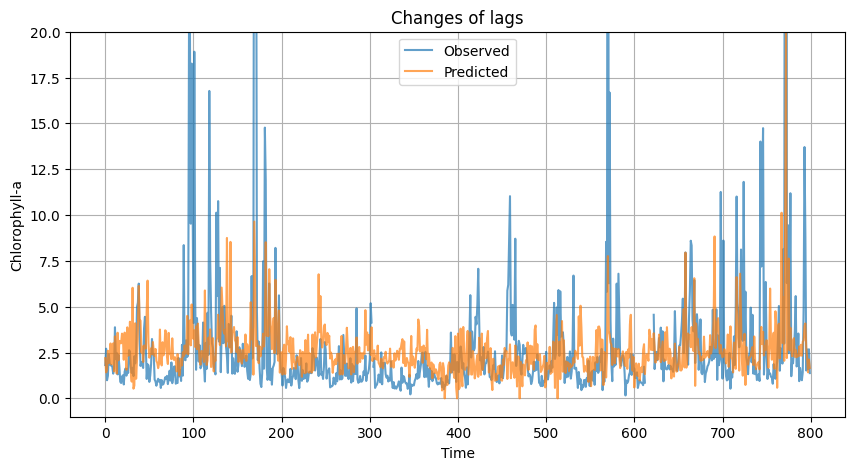

In [24]:
obs = HAB_data['Avg_Chloro']
pred = HAB_gapfill_results['reconstructed_points']
plt.figure(figsize=(10, 5))
plt.plot(obs.index, obs, label="Observed", alpha=0.7)
plt.plot(pred.index, pred, label="Predicted", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Chlorophyll-a")
plt.ylim(-1,20)
plt.title('Changes of lags')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
'''
Binary prediction skill (“bloom” or “no bloom”) is
evaluated by how well bloom predictions (5% largest predicted values)
correspond to bloom observations (5%largest observed values)
Input: Series of observed chlorophyll-a, series of predicted chlorophyll-1
Output: Arrray containing [Accuracy, True Positive Rate, False Positive Rate, True Negative Rate, False Negative Rate]
'''
def bloom_binary_prediction(obs,pred):
    df = pd.DataFrame({'obs': obs, 'pred': pred}).dropna()  
    obs, pred = df['obs'], df['pred']
    obs_bloom_95 = np.percentile(obs, 95) #incorrect
    print(obs_bloom_95)
    pred_bloom_95 = np.percentile(pred, 95) #incorrect
    print(pred_bloom_95)
    obs_blooms = obs > obs_bloom_95
    pred_blooms = pred > pred_bloom_95
    Accuracy = 1 - (obs_blooms ^ pred_blooms).mean()
    True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
    False_pos = ((~obs_blooms) & pred_blooms).sum() / (~obs_blooms).sum()
    True_neg = ((~obs_blooms) & (~pred_blooms)).sum() / (~obs_blooms).sum()
    False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()
    
    return [Accuracy, True_pos, False_pos, True_neg, False_neg]
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [26]:
rmse(HAB_data_t['Avg_Chloro'],HAB_gapfill_results['reconstructed_points'])

5.559378111163222

In [27]:
bloom_binary_prediction(HAB_data['Avg_Chloro'],HAB_gapfill_results['reconstructed_points'])

7.752999999999979
4.501377890503835


[0.9291139240506329, 0.3, 0.037333333333333336, 0.9626666666666667, 0.7]

In [28]:
HAB_data['Avg_Chloro'].isna().sum()

10